In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetx128/datasetX3_reverse_128.pt
/kaggle/input/datasetx3-noaugmen/datasetX3_reverse.pt


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [3]:
torch.cuda.empty_cache()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
config = {
    'batch_size': 64,
    'latent_dim': 128,
    'image_size': (256, 256),
    'epochs': 250,
    'lr': 3e-4,
    'beta': 2,
}

In [6]:
# config = {
#     'batch_size': 64,
#     'latent_dim': 2,
#     'image_size': (256, 256),  # Updated to 256x256 as requested
#     'epochs': 250,
#     'lr': 3e-4,
#     'beta': 4.0,  # Weight for KL divergence
# }

In [7]:
data = torch.load('/kaggle/input/datasetx3-noaugmen/datasetX3_reverse.pt').to(device)

/tmp/ipykernel_31/261631792.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/kaggle/input/datasetx3-noaugmen/datasetX3_reverse.pt').to(device)


In [8]:
data.shape

torch.Size([1115, 3, 256, 256])

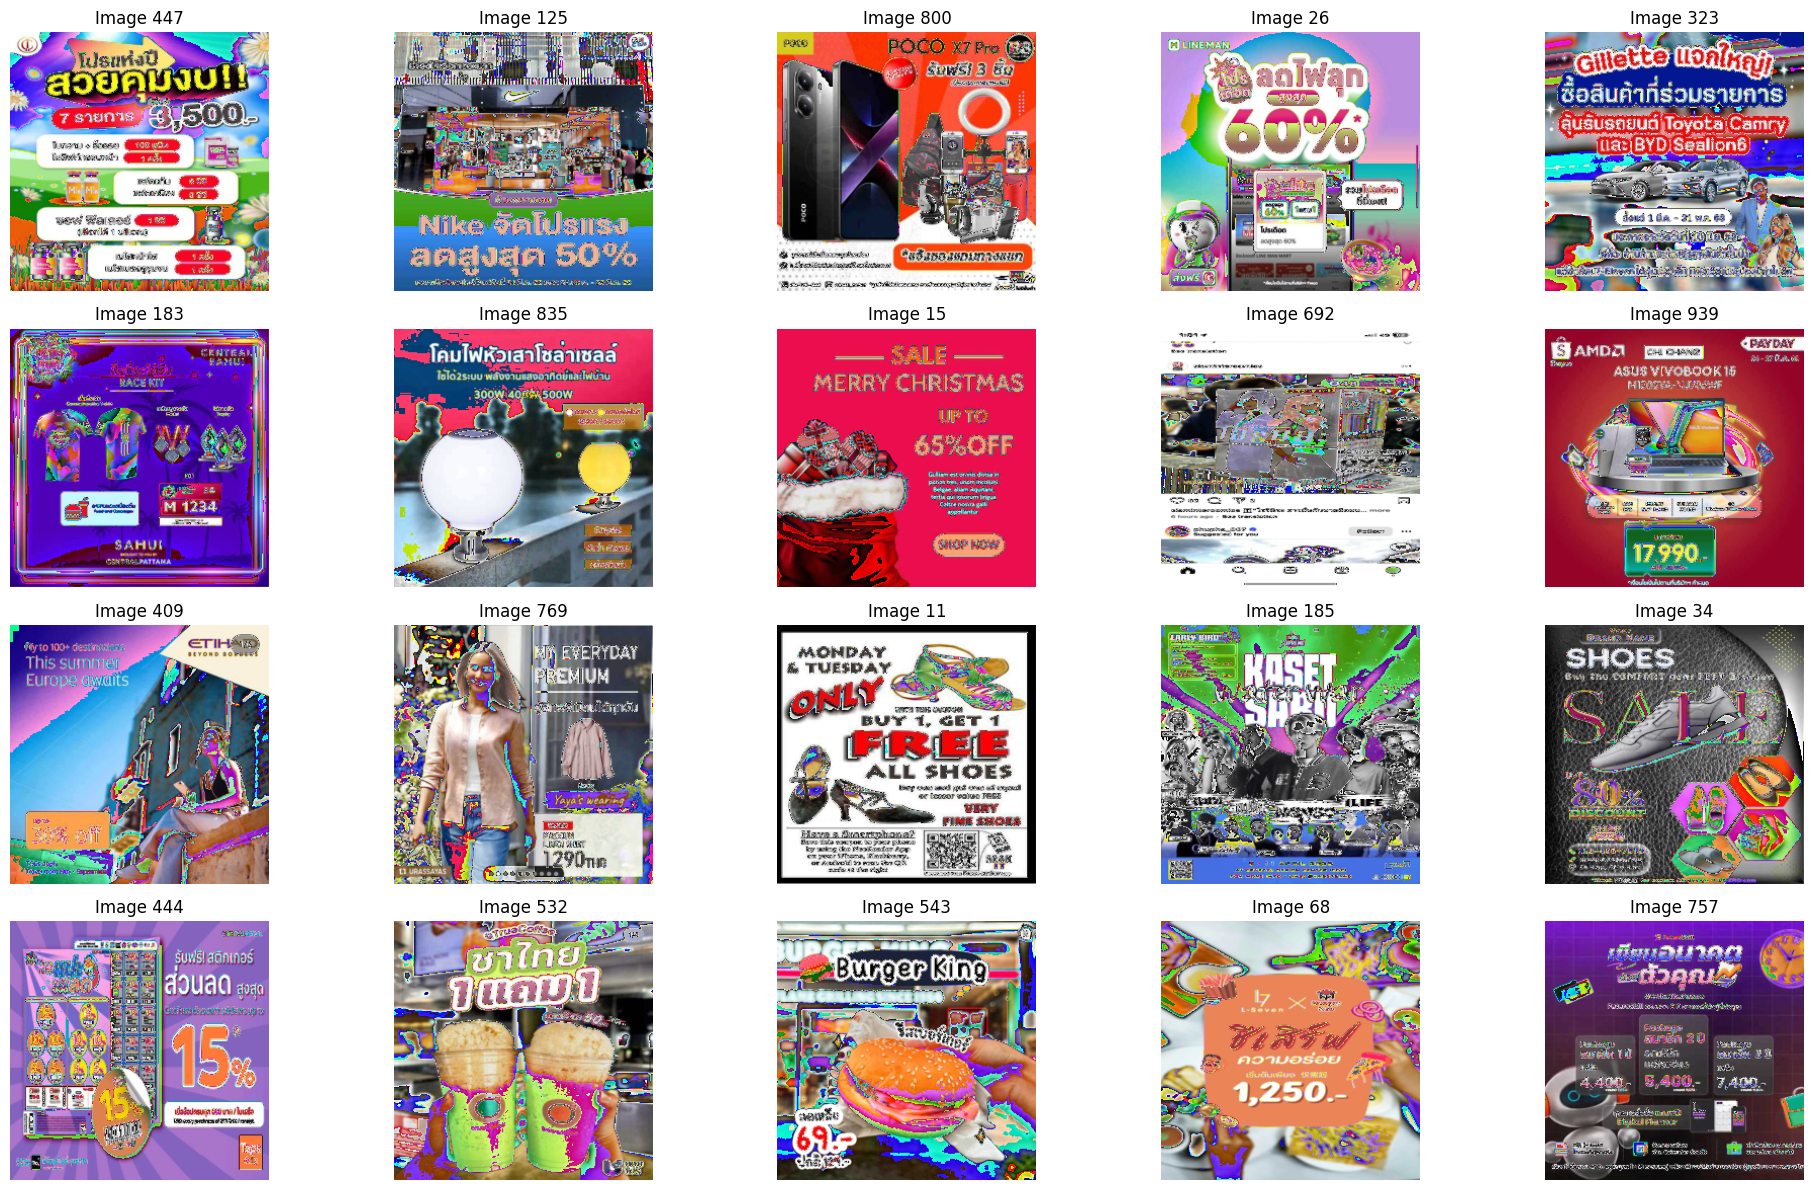

In [9]:
import random

random_indices = random.sample(range(data.size(0)), 20)
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    image = transforms.ToPILImage()(data[idx].cpu())
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Image {idx + 1}')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.7, random_state=42)

In [11]:
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

In [14]:
class GaussianNoise(nn.Module):
    def __init__(self, mean=0.0, std=1.0):
        super(GaussianNoise, self).__init__()
        self.mean = mean
        self.std = std

    def forward(self, x):
        noise = torch.normal(self.mean, self.std, size=x.size()).to(x.device)
        return x + noise

In [16]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


In [17]:
# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)

In [18]:
# Residual Block with CBAM
class ResidualCBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualCBAMBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

        self.ca = ChannelAttention(in_channels)
        self.sa = SpatialAttention()

    def forward(self, x):
        residual = x
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.ca(out) * out
        out = self.sa(out) * out
        out += residual
        return F.gelu(out)

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.gelu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Residual Connection
        return F.gelu(out)

In [20]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=config['latent_dim'], beta=config['beta']):
        super(BetaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta  # Regularization strength parameter for β-VAE

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

        # Calculate size after convolutions
        self.fc_size = 1024 * 4 * 4

        # Latent representation
        self.fc_mu = nn.Linear(self.fc_size, latent_dim)
        self.fc_logvar = nn.Linear(self.fc_size, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, self.fc_size)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv6 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        # Batch normalization 
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.bn6 = nn.BatchNorm2d(1024)

        self.bn7 = nn.BatchNorm2d(512)
        self.bn8 = nn.BatchNorm2d(256)
        self.bn9 = nn.BatchNorm2d(128)
        self.bn10 = nn.BatchNorm2d(64)
        self.bn11 = nn.BatchNorm2d(32)

        # Residual Block
        self.res_block1 = ResidualCBAMBlock(32)
        self.res_block2 = ResidualCBAMBlock(64)
        self.res_block3 = ResidualCBAMBlock(128)
        self.res_block4 = ResidualCBAMBlock(256)
        self.res_block5 = ResidualCBAMBlock(512)

        self.dec_res_block1 = ResidualCBAMBlock(512)
        self.dec_res_block2 = ResidualCBAMBlock(256)
        self.dec_res_block3 = ResidualCBAMBlock(128)
        self.dec_res_block4 = ResidualCBAMBlock(64)

        self.dropout = nn.Dropout(0.3)
        self.gaussian_noise = GaussianNoise(mean=0.0, std=0.1)

    def encode(self, x):
        # Encoder forward pass
        x = F.gelu(self.bn1(self.conv1(x)))
        x = self.res_block1(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.res_block2(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.res_block3(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn4(self.conv4(x)))
        x = self.res_block4(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn5(self.conv5(x)))
        x = self.res_block5(x)
        x = self.gaussian_noise(x)
        x = F.gelu(self.bn6(self.conv6(x)))
        x = x.view(-1, self.fc_size)
        x = self.dropout(x)
        # Return mean and log variance of the latent distribution
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        # Decoder forward pass
        x = F.gelu(self.fc_decoder(z))
        x = x.view(-1, 1024, 4, 4)

        x = F.gelu(self.bn7(self.deconv1(x)))
        x = self.dec_res_block1(x)
        x = F.gelu(self.bn8(self.deconv2(x)))
        x = self.dec_res_block2(x)
        x = F.gelu(self.bn9(self.deconv3(x)))
        x = self.dec_res_block3(x)
        x = F.gelu(self.bn10(self.deconv4(x)))
        x = self.dec_res_block4(x)
        x = F.gelu(self.bn11(self.deconv5(x)))
        x = torch.tanh(self.deconv6(x))  # Output in range [-1, 1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        # Reconstruction loss (MSE)
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Total loss with beta weighting for stronger regularization
        return recon_loss + self.beta * kl_loss, recon_loss, kl_loss


In [21]:
torch.cuda.empty_cache()

In [22]:
model = BetaVAE(latent_dim=config['latent_dim'], beta=config['beta']).to(device)
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

In [23]:
log_interval = 10
# Lists to store losses
train_losses = []
recon_losses = []
kl_losses = []
vali_loss = []

In [24]:
torch.cuda.empty_cache()

In [25]:
from tqdm import tqdm

In [26]:
best_val_loss = float('inf')
patience = 30
patience_counter = 0
early_stop = False

print("Starting training...")
for epoch in range(config['epochs']):
    model.train()
    train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    train_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']} [Train]", leave=False)
    for batch_idx, (batch,) in enumerate(train_bar):
        batch = batch.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, batch, mu, logvar)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

        train_bar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Recon": f"{recon_loss.item():.4f}",
            "KL": f"{kl_loss.item():.4f}"
        })

    # Average loss for the epoch
    avg_loss = train_loss / len(dataloader.dataset)
    avg_recon_loss = epoch_recon_loss / len(dataloader.dataset)
    avg_kl_loss = epoch_kl_loss / len(dataloader.dataset)

    train_losses.append(avg_loss)
    recon_losses.append(avg_recon_loss)
    kl_losses.append(avg_kl_loss)

    model.eval()
    val_loss = 0
    val_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{config['epochs']} [Val]", leave=False)
    with torch.no_grad():
        for batch_idx, (val_batch,) in enumerate(val_bar):
            val_batch = val_batch.to(device)
            recon_batch, mu, logvar = model(val_batch)
            loss, _, _ = model.loss_function(recon_batch, val_batch, mu, logvar)
            val_loss += loss.item()
            val_bar.set_postfix({"Val Loss": f"{loss.item():.4f}"})

    avg_val_loss = val_loss / len(val_dataloader.dataset)
    vali_loss.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    # Early Stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model_l128.pth')
        print(f"Epoch {epoch+1}: New best model saved with val loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best val loss: {best_val_loss:.4f}")
            early_stop = True

    if (epoch + 1) % log_interval == 0:
        print(f"Epoch: {epoch+1}/{config['epochs']} | Train Loss: {avg_loss:.4f} | "
              f"Recon Loss: {avg_recon_loss:.4f} | KL Loss: {avg_kl_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Patience: {patience_counter}/{patience}")

    if early_stop:
        break

Starting training...


Epoch 1: New best model saved with val loss: 92058.0912


Epoch 2: New best model saved with val loss: 91716.0941


Epoch 3: New best model saved with val loss: 91611.9878


Epoch 4: New best model saved with val loss: 91482.3646


Epoch 5: New best model saved with val loss: 91206.0970


Epoch 7: New best model saved with val loss: 88271.3531


Epoch: 10/250 | Train Loss: 77613.7326 | Recon Loss: 77082.0595 | KL Loss: 265.8370 | Val Loss: 94054.7193 | Patience: 3/30


Epoch 12: New best model saved with val loss: 82705.7881


Epoch 14: New best model saved with val loss: 66467.4655


Epoch 16: New best model saved with val loss: 59809.1863


Epoch 18: New best model saved with val loss: 57915.9773


Epoch 20: New best model saved with val loss: 56444.0665
Epoch: 20/250 | Train Loss: 53460.4843 | Recon Loss: 52875.9469 | KL Loss: 292.2687 | Val Loss: 56444.0665 | Patience: 0/30


Epoch 21: New best model saved with val loss: 55365.4820


Epoch 22: New best model saved with val loss: 54672.9424


Epoch 24: New best model saved with val loss: 52850.4021


Epoch 25: New best model saved with val loss: 52100.6585


Epoch 26: New best model saved with val loss: 51988.4240


Epoch 28: New best model saved with val loss: 51084.1121


Epoch 30: New best model saved with val loss: 51030.3366
Epoch: 30/250 | Train Loss: 45283.3239 | Recon Loss: 44717.7391 | KL Loss: 282.7924 | Val Loss: 51030.3366 | Patience: 0/30


Epoch 34: New best model saved with val loss: 50967.3912


Epoch 37: New best model saved with val loss: 50268.6661


Epoch 38: New best model saved with val loss: 49641.4077


Epoch 40: New best model saved with val loss: 49250.1728
Epoch: 40/250 | Train Loss: 36888.2225 | Recon Loss: 36210.9669 | KL Loss: 338.6275 | Val Loss: 49250.1728 | Patience: 0/30


Epoch 41: New best model saved with val loss: 49093.9635


Epoch 43: New best model saved with val loss: 48720.4389


Epoch 45: New best model saved with val loss: 48289.9275


Epoch: 50/250 | Train Loss: 30264.8168 | Recon Loss: 29570.3943 | KL Loss: 347.2112 | Val Loss: 49247.3210 | Patience: 5/30


Epoch 57: New best model saved with val loss: 47744.3498


Epoch: 60/250 | Train Loss: 24912.6910 | Recon Loss: 24218.2399 | KL Loss: 347.2255 | Val Loss: 49669.4372 | Patience: 3/30


Epoch: 70/250 | Train Loss: 21920.3310 | Recon Loss: 21240.1626 | KL Loss: 340.0843 | Val Loss: 48578.3837 | Patience: 13/30


Epoch: 80/250 | Train Loss: 20027.8928 | Recon Loss: 19366.7743 | KL Loss: 330.5594 | Val Loss: 49253.5042 | Patience: 23/30


Early stopping triggered after 87 epochs. Best val loss: 47744.3498


In [63]:
torch.cuda.empty_cache()

In [64]:
torch.cuda.empty_cache()

Text(0.5, 0, 'Epoch')

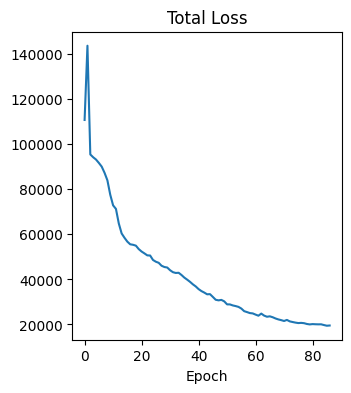

In [65]:
# Plot loss curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses)
plt.title('Total Loss')
plt.xlabel('Epoch')

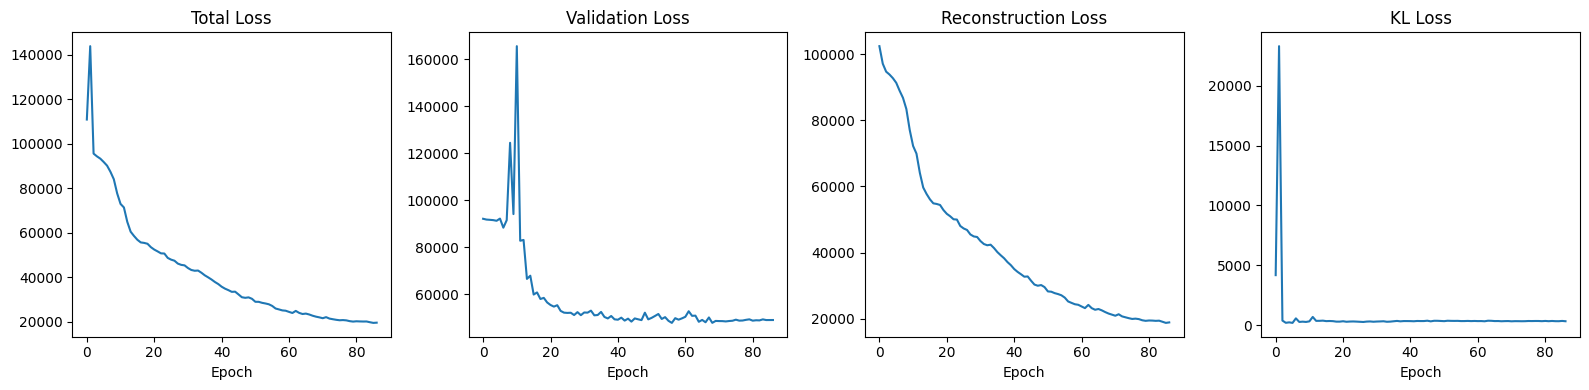

In [66]:
# Plot loss curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses)
plt.title('Total Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 2)
plt.plot(vali_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 3)
plt.plot(recon_losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')

plt.subplot(1, 4, 4)
plt.plot(kl_losses)
plt.title('KL Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()
# plt.savefig('vae_training_losses.png')
# plt.close()

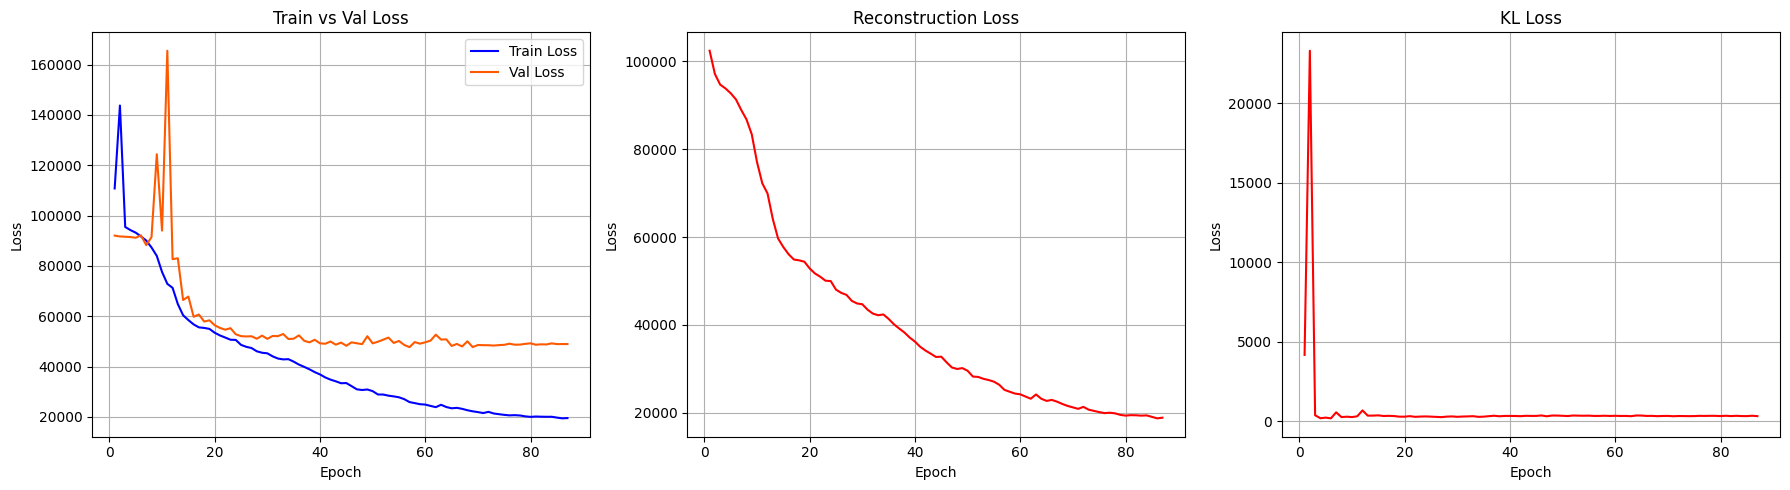

In [74]:
c_epochs = list(range(1, len(train_losses) + 1))
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: Train vs Val Loss
axs[0].plot(c_epochs, train_losses, label='Train Loss', color='blue')
axs[0].plot(c_epochs, vali_loss, label='Val Loss', color='#FF5900')
axs[0].set_title('Train vs Val Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Reconstruction Loss
axs[1].plot(c_epochs, recon_losses, label='Recon Loss', color='red')
axs[1].set_title('Reconstruction Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

# Subplot 3: KL Loss
axs[2].plot(c_epochs, kl_losses, label='KL Loss', color='red')
axs[2].set_title('KL Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [69]:
if early_stop and os.path.exists('/kaggle/working/best_model_reverse.pth'):
    model.load_state_dict(torch.load('/kaggle/working/best_model_reverse.pth'))
    print("Loaded best model from checkpoint.")

In [34]:
torch.cuda.empty_cache()

In [35]:
# Extract features from the latent space
def extract_latent_features(model, dataloader, device):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(dataloader):
            batch = batch.to(device)
            mu, _ = model.encode(batch)
            latent_vectors.append(mu.cpu().numpy())

    return np.vstack(latent_vectors)

In [36]:
# Create a new dataloader without shuffling to maintain order
eval_dataset = TensorDataset(data)
eval_dataloader = DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False)

# Extract latent features
print("Extracting latent features...")
latent_features = extract_latent_features(model, eval_dataloader, device)
print(f"Latent features shape: {latent_features.shape}")

Extracting latent features...
Latent features shape: (1115, 128)


In [37]:
import seaborn as sns

def plot_latent_space(z_mean, labels=None, title="Latent Space", figsize=(8, 6)):
    """
    Visualize 2D latent space from VAE.

    Parameters:
    - z_mean: np.array of shape (n_samples, 2)
        Latent vectors (usually the mean from encoder)
    - labels: np.array or list of shape (n_samples,), optional
        Class labels for coloring points
    - title: str
        Title of the plot
    - figsize: tuple
        Size of the figure
    """
    plt.figure(figsize=figsize)
    if labels is not None:
        palette = sns.color_palette("hsv", len(np.unique(labels)))
        sns.scatterplot(x=z_mean[:, 0], y=z_mean[:, 1], hue=labels, palette=palette, s=30, alpha=0.7, edgecolor='k')
        plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(z_mean[:, 0], z_mean[:, 1], s=30, alpha=0.7, edgecolor='k')
    
    plt.title(title)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

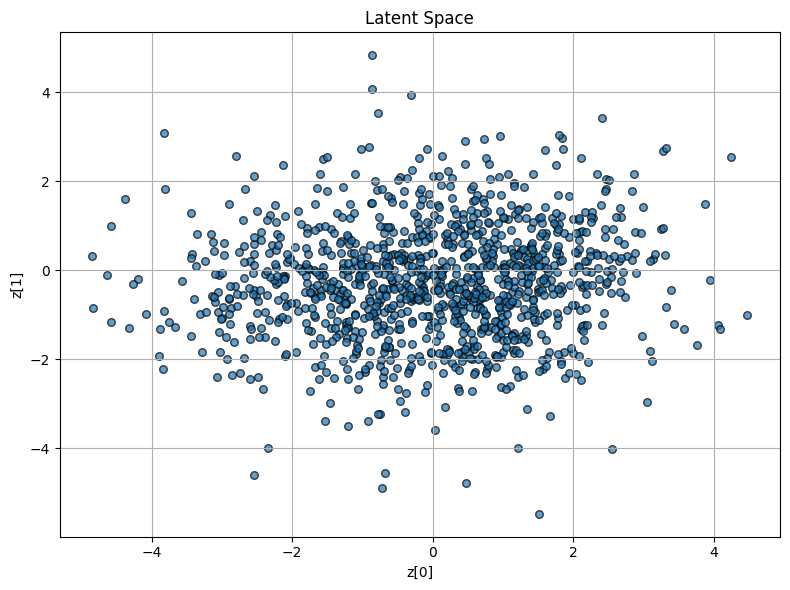

In [38]:
plot_latent_space(latent_features)

In [71]:
# File Save
np.save('/kaggle/working/latent_featuresX4.npy', latent_features)

In [40]:
torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


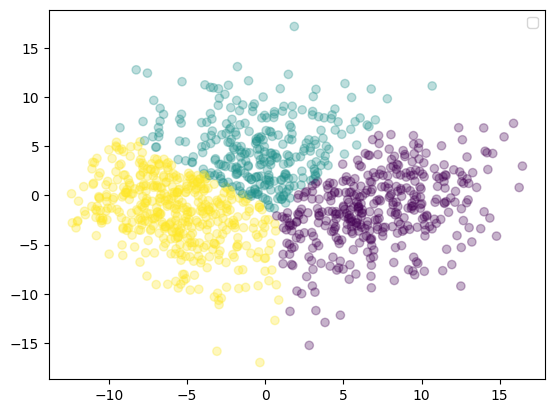

In [41]:
pca = PCA(n_components=2)
pca_map = pca.fit_transform(latent_features)

kmeans = KMeans(n_clusters=3, random_state=42)
lab = kmeans.fit_predict(pca_map)

plt.scatter(pca_map[:, 0], pca_map[:, 1], c=lab, cmap='viridis', alpha=0.3)
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import silhouette_score

silhouette_score(pca_map, lab)

0.38824815

In [43]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


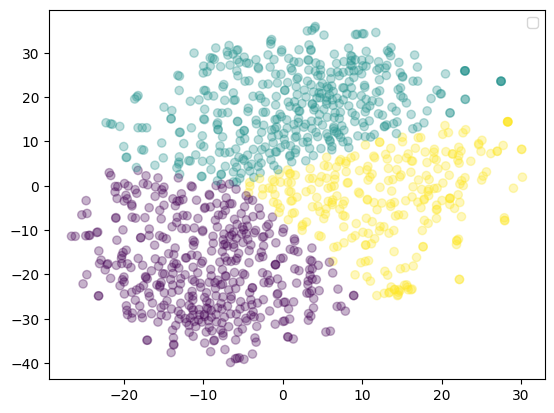

In [44]:
tsne = TSNE(n_components=2)
tsne_map = tsne.fit_transform(latent_features)

lab = kmeans.fit_predict(tsne_map)

plt.scatter(tsne_map[:, 0], tsne_map[:, 1], c=lab, cmap='viridis', alpha=0.3)
plt.legend()
plt.show()

In [45]:
silhouette_score(tsne_map, lab)

0.40133676

In [46]:
def get_feature_maps(model, x):
    fmap1 = model.bn1(model.conv1(x))
    fmap2 = model.bn2(model.conv2(F.gelu(fmap1)))
    fmap3 = model.bn3(model.conv3(F.gelu(fmap2)))
    fmap4 = model.bn4(model.conv4(F.gelu(fmap3)))
    fmap5 = model.bn5(model.conv5(F.gelu(fmap4)))
    fmap6 = model.bn6(model.conv6(F.gelu(fmap5)))
    return [fmap1, fmap2, fmap3, fmap4, fmap5, fmap6]

In [47]:
def visualize_feature_maps(feature_maps, layer_names=None, max_channels=10):
    for i, fmap in enumerate(feature_maps):
        fmap = fmap.detach().cpu()
        num_channels = min(fmap.shape[1], max_channels)

        fig, axs = plt.subplots(1, num_channels, figsize=(15, 4))
        fig.suptitle(f"Feature Map Layer {layer_names[i] if layer_names else i}", fontsize=16)

        for j in range(num_channels):
            axs[j].imshow(fmap[0, j], cmap='viridis')
            axs[j].axis('off')
            axs[j].set_title(f"Channel {j}")
        plt.tight_layout()
        plt.show()

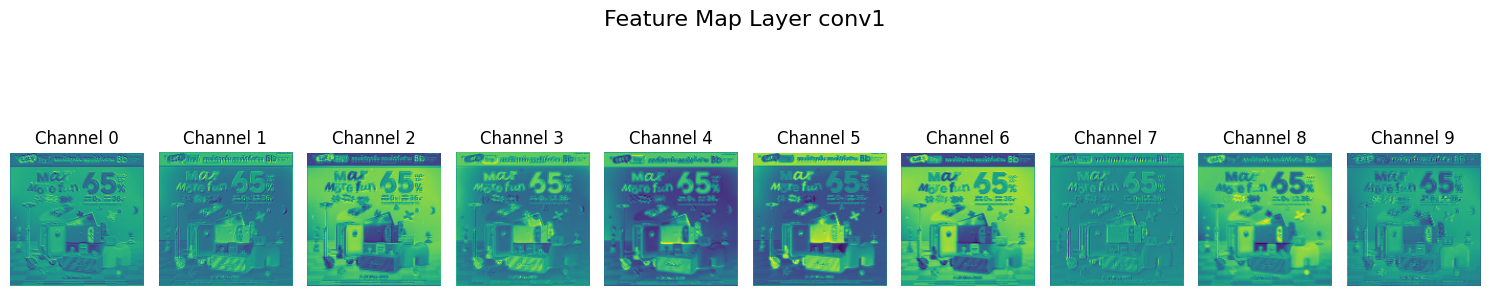

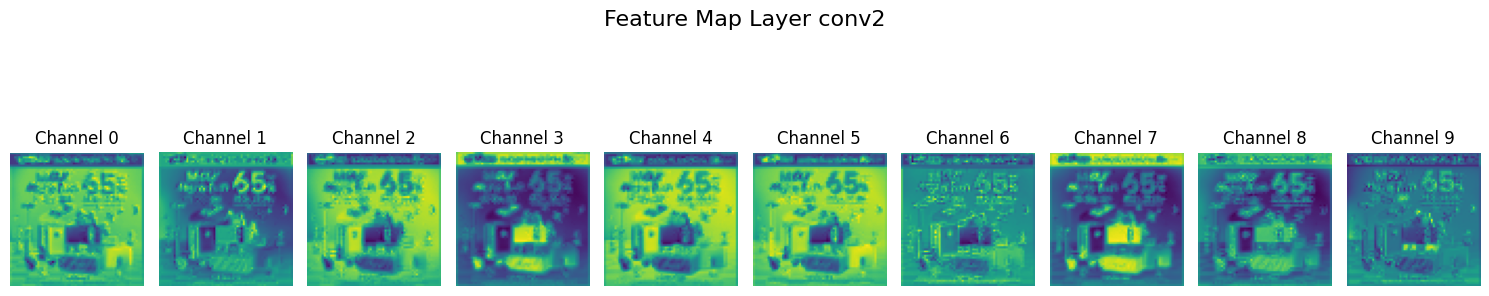

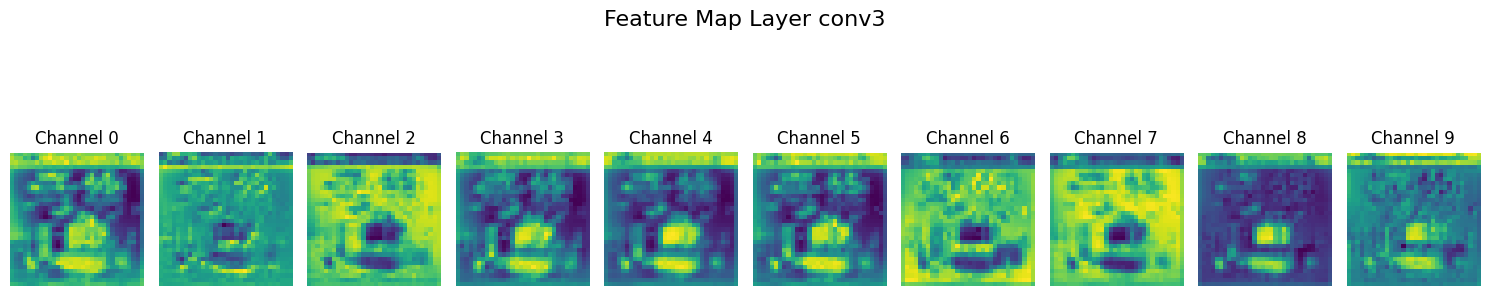

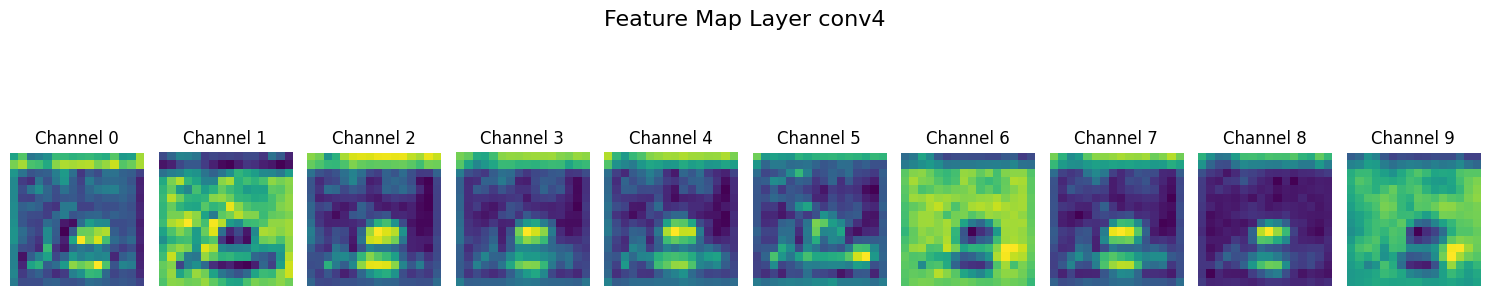

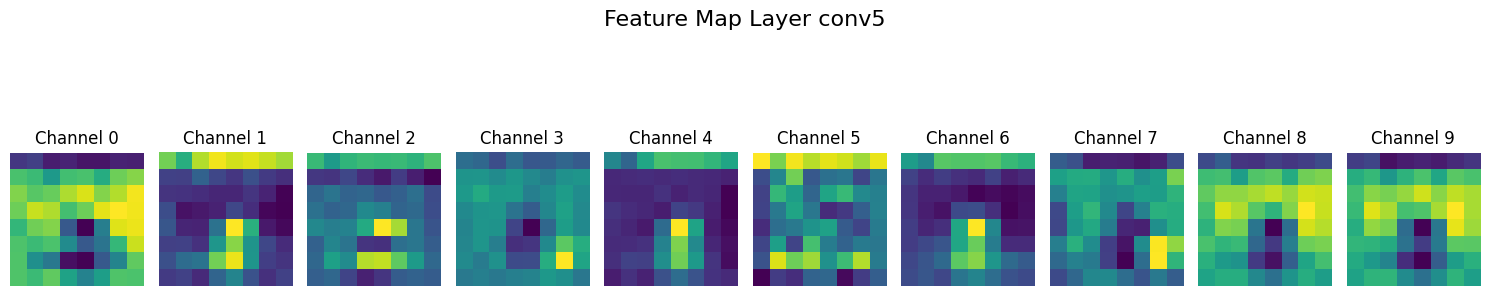

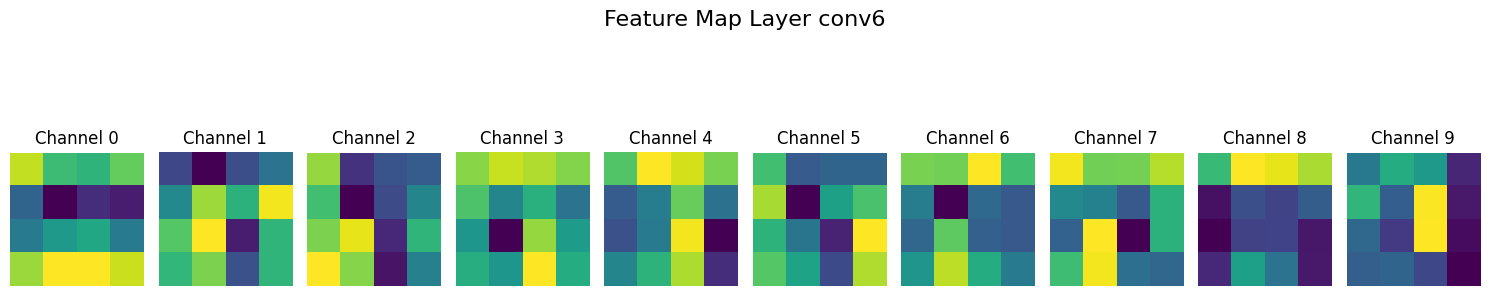

In [48]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    data_iter = iter(val_dataloader)
    image_batch = next(iter(val_dataloader))
    if isinstance(image_batch, (tuple, list)):
        images = image_batch[0]  
    else:
        images = image_batch
    
    x = images[0].unsqueeze(0).to(device)  

    fmaps = get_feature_maps(model, x)
    visualize_feature_maps(fmaps, layer_names=["conv1", "conv2", "conv3", "conv4", "conv5", "conv6"])



In [49]:
# config2 = {
#     "latent_dim": 128,
#     "num_classes": len(set(lab)),
#     "img_size": 256,
#     "channels": 3,
#     "lr": 2e-4,
#     "betas": (0.5, 0.999)
# }

In [50]:
# latent_dim = config2["latent_dim"]
# num_classes = config2["num_classes"]
# img_size = config2["img_size"]
# channels = config2["channels"]

In [51]:
# # One-hot Encoding for labels
# def one_hot(labels, num_classes):
#     return F.one_hot(labels, num_classes).float()

In [52]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.label_embed = nn.Embedding(num_classes, num_classes)

#         self.fc = nn.Sequential(
#             nn.Linear(latent_dim + num_classes, 512 * 8 * 8),
#             nn.BatchNorm1d(512 * 8 * 8),
#             nn.ReLU()
#         )

#         self.deconv = nn.Sequential(
#             nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 16x16
#             nn.BatchNorm2d(256),
#             nn.ReLU(),

#             nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 32x32
#             nn.BatchNorm2d(128),
#             nn.ReLU(),

#             nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 64x64
#             nn.BatchNorm2d(64),
#             nn.ReLU(),

#             nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 128x128
#             nn.BatchNorm2d(32),
#             nn.ReLU(),

#             nn.ConvTranspose2d(32, channels, 4, 2, 1),  # 256x256
#             nn.Tanh()
#         )

#     def forward(self, noise, labels):
#         label_input = self.label_embed(labels)
#         x = torch.cat([noise, label_input], dim=1)
#         x = self.fc(x)
#         x = x.view(x.size(0), 512, 8, 8)
#         return self.deconv(x)

In [53]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.label_embed = nn.Embedding(num_classes, num_classes)

#         self.conv = nn.Sequential(
#             nn.Conv2d(channels + num_classes, 64, 4, 2, 1),  # 128x128
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(64, 128, 4, 2, 1),  # 64x64
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(128, 256, 4, 2, 1),  # 32x32
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.2),

#             nn.Conv2d(256, 512, 4, 2, 1),  # 16x16
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.2)
#         )

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512 * 16 * 16, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, img, labels):
#         label_input = self.label_embed(labels).view(labels.size(0), num_classes, 1, 1)
#         label_input = label_input.expand(labels.size(0), num_classes, img_size, img_size)
#         x = torch.cat([img, label_input], dim=1)
#         features = self.conv(x)
#         return self.fc(features)


In [54]:
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)

In [55]:
# g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr'], betas=config2["betas"])
# d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr'], betas=config2["betas"])

In [56]:
# adversarial_loss = nn.BCELoss()

In [57]:
# num_epochs = 20
# latent_features = torch.tensor(latent_features).float().to(device)
# lab = torch.tensor(lab).long().to(device)

In [58]:
# g_losses = []
# d_losses = []

In [59]:
# data = torch.tensor(data).float()  
# lab = torch.tensor(lab).long()     
# dataset2 = TensorDataset(data, lab)
# train_loader = DataLoader(dataset2, batch_size=64, shuffle=True)

In [60]:
# for epoch in range(num_epochs):
#     generator.train()
#     discriminator.train()

#     epoch_g_loss = 0.0
#     epoch_d_loss = 0.0
#     n_batches = 0

#     for real_imgs, labels in tqdm(train_loader):
#         batch_size = real_imgs.size(0)
#         real_imgs = real_imgs.to(device)
#         labels = labels.to(device)

#         # ดึง condition จาก latent features (ใช้ labels เป็น index)
#         cond_labels = labels
#         cond_features = latent_features[labels]  # Optional: ถ้าอยากใช้ feature จาก cluster

#         # Noise สำหรับ Generator
#         z = torch.randn(batch_size, config2["latent_dim"]).to(device)

#         valid = torch.ones(batch_size, 1).to(device)
#         fake = torch.zeros(batch_size, 1).to(device)

#         # ---- Train Generator ----
#         g_optimizer.zero_grad()
#         gen_imgs = generator(z, cond_labels)
#         g_loss = adversarial_loss(discriminator(gen_imgs, cond_labels), valid)
#         g_loss.backward()
#         g_optimizer.step()

#         # ---- Train Discriminator ----
#         d_optimizer.zero_grad()
#         real_loss = adversarial_loss(discriminator(real_imgs, cond_labels), valid)
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), cond_labels), fake)
#         d_loss = (real_loss + fake_loss) / 2
#         d_loss.backward()
#         d_optimizer.step()

#         # ---- Logging ----
#         epoch_g_loss += g_loss.item()
#         epoch_d_loss += d_loss.item()
#         n_batches += 1

#     # เก็บ loss
#     avg_g_loss = epoch_g_loss / n_batches
#     avg_d_loss = epoch_d_loss / n_batches
#     g_losses.append(avg_g_loss)
#     d_losses.append(avg_d_loss)

#     print(f"[Epoch {epoch+1}/{num_epochs}]  G_loss: {avg_g_loss:.4f} | D_loss: {avg_d_loss:.4f}")

In [61]:

# plt.plot(g_losses, label="Generator Loss")
# plt.plot(d_losses, label="Discriminator Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.title("GAN Training Loss")
# plt.show()


In [62]:
# n_samples = 8

# z = torch.randn(n_samples, config2["latent_dim"]).to(device)

# sampled_labels = torch.randint(0, config2["num_classes"], (n_samples,)).to(device)

# generator.eval()
# with torch.no_grad():
#     gen_imgs = generator(z, sampled_labels)

# gen_imgs = (gen_imgs + 1) / 2

# fig, axs = plt.subplots(1, n_samples, figsize=(15, 3))
# for i in range(n_samples):
#     img = gen_imgs[i].cpu().permute(1, 2, 0).numpy()
#     axs[i].imshow(img)
#     axs[i].axis("off")
#     axs[i].set_title(f"Class {sampled_labels[i].item()}")
# plt.show()